# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
# dataDir = "/home/ababil/BUET/AV/location-2"
# dataDir = "C:/Users/Zenbook325E/Downloads/csv"
dataDir = "D:/AV/Code/location-2"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\Code\behavior-hypotheses\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [5]:
sceneId = 222
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [6]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        speedCol='speed',
        accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = 0.0,
    maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

In [7]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


4172

### Right side of the vertical axis is negative

In [8]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,236,18001,222,9.0,8.795651,4.466058,0.505071,0.197380,0.009580,0.143155,0.542269,0.000000,0.000000,0.143475,-0.000000,-0.000000
1,18,238,18001,222,9.0,8.693964,4.431674,0.508432,0.171917,-0.016808,0.127315,0.536711,0.101686,0.034383,0.128420,0.101686,0.034383
2,18,240,18001,222,9.0,8.590706,4.402693,0.516291,0.144904,-0.039294,0.135063,0.536241,0.204945,0.063364,0.140663,0.204945,0.063364
3,18,242,18001,222,9.0,8.487226,4.379976,0.517401,0.113585,-0.005551,0.156596,0.529722,0.308425,0.086081,0.156695,0.308425,0.086081
4,18,244,18001,222,9.0,8.383189,4.362756,0.520184,0.086103,-0.013914,0.137408,0.527262,0.412462,0.103302,0.138111,0.412462,0.103302
5,18,246,18001,222,9.0,8.277729,4.349678,0.527300,0.065389,-0.035581,0.103569,0.531339,0.517922,0.116380,0.109511,0.517922,0.116380
6,18,248,18001,222,9.0,8.170561,4.340949,0.535837,0.043644,-0.042684,0.108727,0.537612,0.625089,0.125108,0.116806,0.625089,0.125108
7,18,250,18001,222,9.0,8.061950,4.335745,0.543059,0.026021,-0.036111,0.088117,0.543682,0.733701,0.130313,0.095229,0.733701,0.130313
8,18,252,18001,222,9.0,7.951176,4.332690,0.553866,0.015275,-0.054035,0.053725,0.554077,0.844475,0.133368,0.076198,0.844475,0.133368
9,18,254,18001,222,9.0,7.838260,4.331050,0.564581,0.008198,-0.053571,0.035387,0.564640,0.957391,0.135007,0.064204,0.957391,0.135007


In [9]:
# plt.boxplot(startingDf["speed"])

In [10]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

In [11]:
# starting023 = startingDf[startingDf["uniqueTrackId"] == 18023].copy()
# visualizer.show(starting023, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
# # starting023.size
# starting023

In [12]:
# starting023 = AngularDisplacementCalculator.addAngularDisplacement(starting023)
# starting023 = AngularDisplacementCalculator.addRelativeAngularDisplacement(starting023)
# starting023

In [13]:
NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

In [14]:
# newAngularDisplacementDf.columns

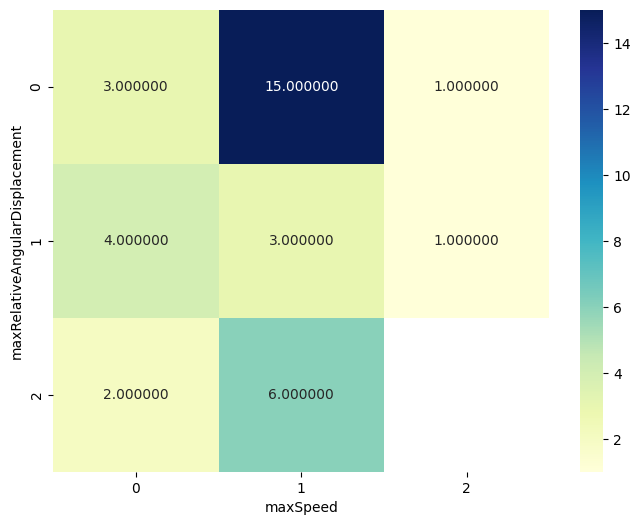

In [18]:
def AngDisVsMaxSpeed(dataframe):
    newAngularDisplacementDf = AngularDisplacementCalculator.getPedAngularDisplacementDf(dataframe)
    col1 = 'maxRelativeAngularDisplacement'
    col2 = 'maxSpeed'

    newAngularDisplacementDf['category1'] = assign_category(newAngularDisplacementDf[col1], NO_OF_CATEGORY)
    newAngularDisplacementDf['category2'] = assign_category(newAngularDisplacementDf[col2], NO_OF_CATEGORY)

    heatmapDf = pd.DataFrame(columns = [col1, col2, 'count'])
    heatmapDf['maxRelativeAngularDisplacement'] = newAngularDisplacementDf['category1']
    heatmapDf['maxSpeed'] = newAngularDisplacementDf['category2']
    heatmapDf['count'] = 1
    heatmapDf = heatmapDf.groupby(['maxRelativeAngularDisplacement', 'maxSpeed']).count().reset_index()
    heatmapDf = heatmapDf.pivot(index='maxRelativeAngularDisplacement', columns='maxSpeed', values='count')

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmapDf, annot=True, fmt=".6f", cmap='YlGnBu')

    plt.xlabel("maxSpeed")
    plt.ylabel("maxRelativeAngularDisplacement")

    x_labels = ["low speed", "medium speed", "high speed"]
    y_labels = ["0", "1", "2"]

    plt.show()



In [28]:
AngDisVsMaxSpeed(startingDf)

,category1,category2,count
0,0,0,45
1,0,1,31
2,0,2,1
3,1,0,32
4,1,1,37
5,1,2,4
6,2,0,10
7,2,1,8
